Without data, machine learning is nothing. After all what will it learn if it has nothing to learn from. Think about everything you've learned throughout your life. All the books you've read, the movies you've watched, the experiences you've lived. Everything you've touched, tasted, heard, felt, smelled. It all comes together to shape who you are and what you know. Our brains adapt and change to all of this input. Our brains _learn_. Take away all of the memories and experiences and what are we left with? Thoughts maybe, but of what? Without the context of our life there isn't much to think about. Machine learning models work like our brain, but simpler. They take data and try to make sense of it, or _learn_ from it. The more data, the easier it is to learn from, at least in theory.

## Quality vs. quantity

While we will dive into many algorithms over the course of this book, I want to drive home that machine learning models _need_ data to learn. We can have the fanciest neural network on the best GPU cluster in the world, but without data, it's all pointless. To drive this point home let's see some machine learning in action.

We'll start with a line. Nothing special, just the equation `f(x) = x + 1`.

<Axes: >

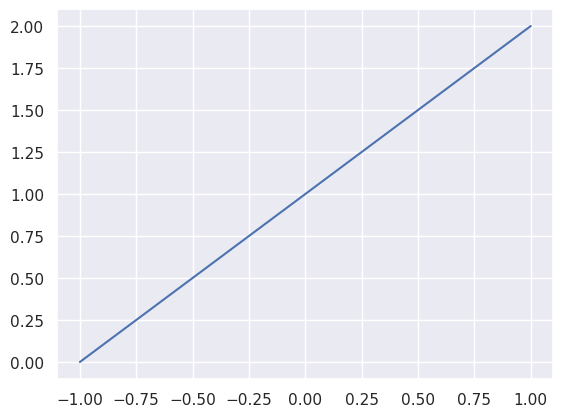

In [1]:
# | eval: false
import seaborn as sns

sns.set_theme(style="darkgrid")


def f(x):
    """Function that applies `x + 1` to `x`."""
    return x + 1

def get_y(xs):
    """Return `y` for every `x` in the list `xs`."""
    return list(map(f, xs))


x = [-1, 1]
y = get_y(x)
sns.lineplot(x=x, y=y)

[I love [`seaborn`](https://seaborn.pydata.org/) for rapid data visualization. It can't do everything perfectly, but it does the common things beautifully.]{.aside}This line is the ground truth. It is real. But let's imagine we don't have the line. We just have a couple random points on the line.

<Axes: >

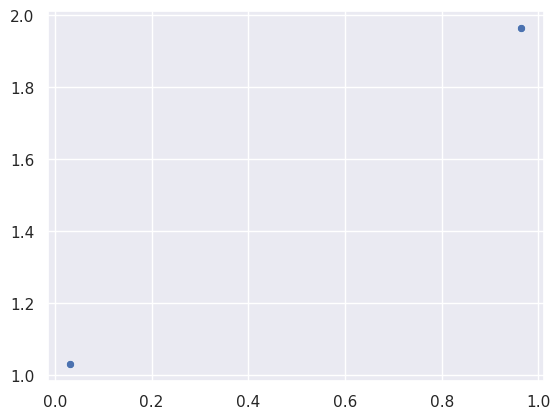

In [2]:
# | eval: false
import random
import pandas as pd

random.seed(100392)


def random_x(n):
    """Return `n` random values from -1 to 1."""
    return [random.uniform(-1, 1) for _ in range(n)]


xs = random_x(2)
ys = get_y(xs)
sns.scatterplot(x=xs, y=ys)

Visually, we could draw a line from dot to dot and we'd get the same line in the previous plot. But we're not interested in figuring out the line ourselves. We're here to have machine learning do it for us. This is already integrated into `seaborn` so there's not much code for us to write. The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function will plot our data points and use machine learning to fit a line to those data points.

<Axes: >

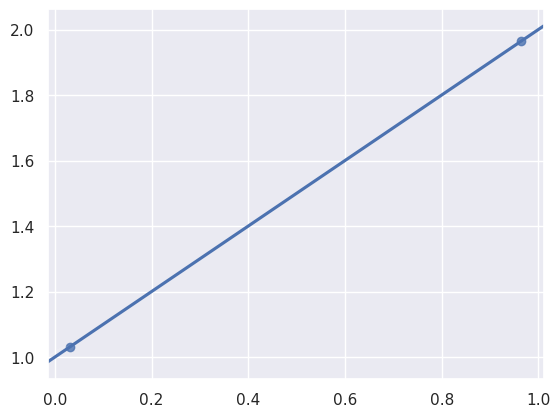

In [3]:
# | eval: false
sns.regplot(x=xs, y=ys, truncate=False, ci=False)

Will you look at that! The line was perfectly predicted based on the data points.

But real world data isn't this simple or this _clean_. There's usually some amount of noise in the data that can affect the quality of predictions. Noise is randomness introduced to the data. It can come from many places like imprecise measurements, mislabelling, or unaccounted variables to name a few.

Now let's imagine we don't have points on the line, but points close to the line. How will this change the predicted line?

<Axes: >

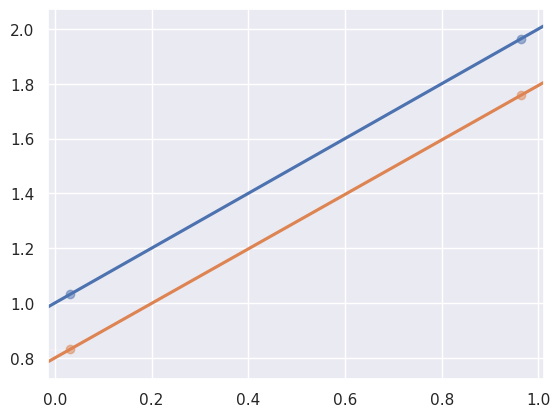

In [4]:
# | eval: false
# Add noise to the data points to simulate noisy data.
def noisy_process(xs, noise):
    """Return `f(x)` with noise."""
    return [
        y + random.uniform(-noise, noise)
        for x, y in zip(xs, get_y(xs))
    ]


ys_noisy = noisy_process(xs, 0.25)

ax = sns.regplot(
    x=xs,
    y=ys,
    truncate=False,
    ci=False,
    scatter_kws={"alpha": 0.5},
)
sns.regplot(
    x=xs,
    y=ys_noisy,
    truncate=False,
    ci=False,
    ax=ax,
    scatter_kws={"alpha": 0.5},
)

Hmm, that doesn't look so bad. The predicted line in orange is pretty close to the real line in blue and has the same slope. But what if we just got lucky and the random noise happened to be low? Maybe we should run it a few more times to be sure.[[`pandas`](https://pandas.pydata.org/docs/) is another great library we'll use over and over again. We'll get to more on that later.]{.aside}

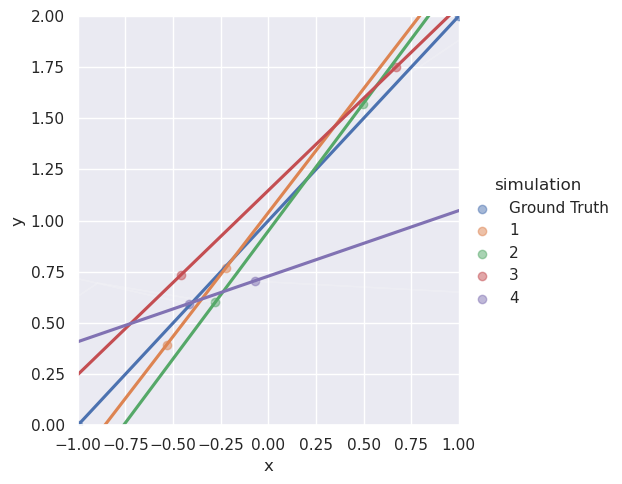

In [5]:
# | eval: false
import pandas as pd


def simulate_n(n, n_points, noise):
    """
    Return a `pd.DataFrame` with `n` separate simulations
    of `n_points`.
    """
    data = []
    real_x = [-1, 1]
    real_y = get_y(real_x)
    for x, y in zip(real_x, real_y):
        data.append(
            {
                "x": x,
                "y": y,
                "simulation": "Ground Truth",
                "noise": noise,
            }
        )
    for i in range(n):
        xs = random_x(n_points)
        ys = noisy_process(xs, noise)
        for x, y in zip(xs, ys):
            data.append(
                {
                    "x": x,
                    "y": y,
                    "simulation": i + 1,
                    "noise": noise,
                }
            )
    return pd.DataFrame(data)


df = simulate_n(4, 2, 0.25)
# `lmplot` is a fancier version of `regplot` that can handle
# multiple lines.
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

Most of these look pretty close to the blue line, the ground truth, but what's going on with simulation 4? The noise confused the machine learning model. It only has two points to work with and given two points it can figure out a line that perfectly lies on those two points. These two points imperfectly represent the real line and so the machine learned the line of this imperfect representation. And it gets worse with more noise.

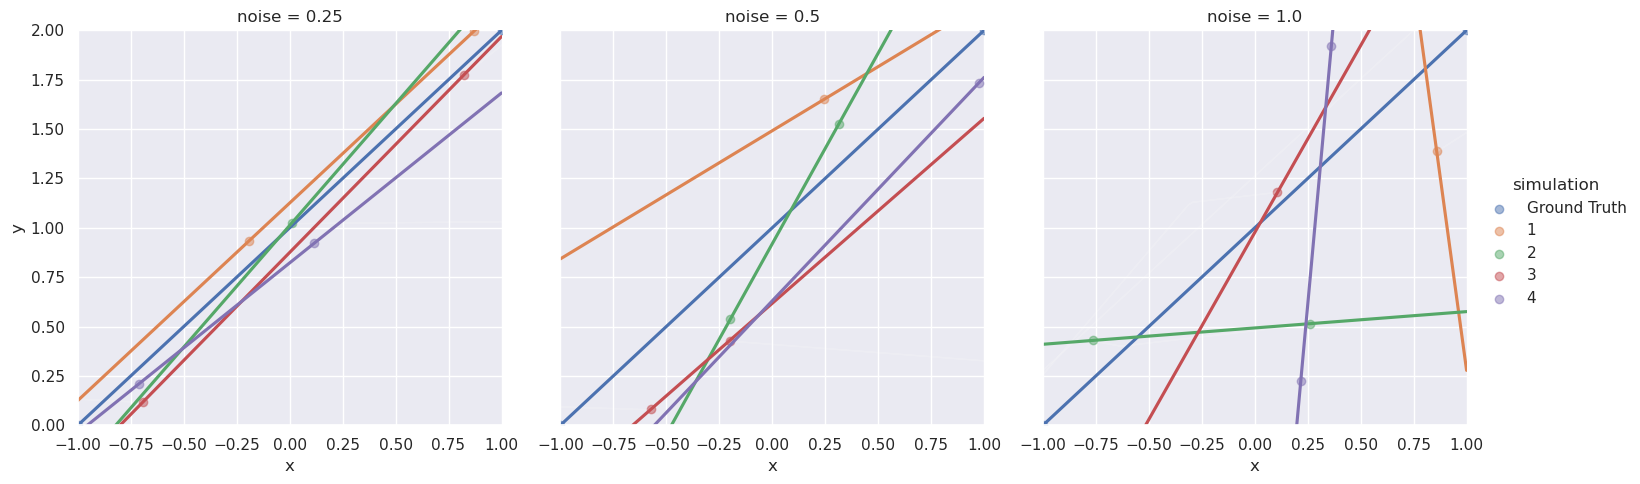

In [6]:
# | eval: false
df = pd.concat(
    [simulate_n(4, 2, noise) for noise in [0.25, 0.5, 1]]
)
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    col="noise",
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

Yup, that's a mess. At `noise = 0.5` the lines start to drift from the real line and at `noise = 1.0` most of them aren't even close. But all is not lost, there is a way to learn from noisy data. Use more of it! Let's try a hundred points per simulation.

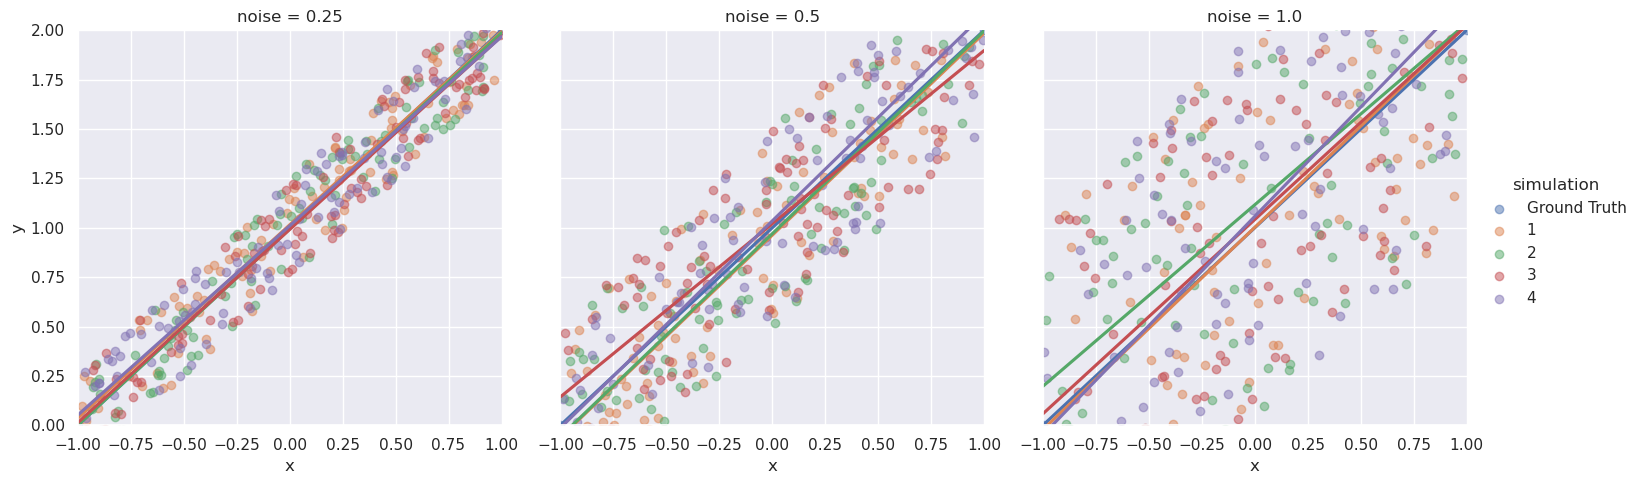

In [7]:
# | eval: false
df = pd.concat(
    [simulate_n(4, 100, noise) for noise in [0.25, 0.5, 1]]
)
sns.lmplot(
    df,
    x="x",
    y="y",
    ci=False,
    hue="simulation",
    truncate=False,
    col="noise",
    scatter_kws={"alpha": 0.5},
    facet_kws={"xlim": (-1, 1), "ylim": (0, 2)},
)

That's night and day compared to two data points. Even when `noise = 1.0` the machine learning model does a good job of finding the line. This is because there's more information to learn from and the machine learning model can separate the noise and zero in on the truth.

The lesson here is data quality is important, but so is data _quantity_. Sometimes the answer is a better machine learning model, but that's not always true, you might just need more data. On the other hand, if you can't get enough data, you may need better _quality_ data. If you're stuck with a small amount of low quality data, then machine learning may not be the answer to your problem.

## The dataset

Our models will be using datasets of movie reviews from IMDB [@maas-EtAl:2011:ACL-HLT2011]. The original datasets can be found at [https://ai.stanford.edu/~amaas/data/sentiment](https://ai.stanford.edu/~amaas/data/sentiment).

::: {.callout-note}
One of the most important chapters in this book is about cleaning data. It's a bonus chapter at the end. It walks through the steps and analysis I performed to clean and prepare the dataset for this book. At this point it's not important. The focus should be on building models as fast as possible and iterating on them. By the end of this book, you should feel comfortable with machine learning, at which point understanding where data comes from and how it's prepared becomes useful. After all we want to apply te things learned here to the real world, and that starts with real world data.

It is still a bonus chapter and not required for understanding machine learning, but I found some suprising things when I cleaned this dataset. If you make it to the end, you really should read it.
:::

I've taken the liberty of further cleaning the data and making it accessible through a Python API so we can get right to work on machine learning and NLP.

This book provides a conda environment file (see the [introduction](intro.qmd#what-this-book-is)) with everything you need to run the code. If you want to access the dataset without setting up the conda environment, you can get access to it through `pip`. If you're just following along through the book website then there's nothing you need to do.

```{.bash code-line-numbers="false"}
$ pip install git+https://github.com/spenceforce/NLP-Simple-to-Spectacular
```

Let's get a feel for the datasets before we move on to machine learning. There are two movie review datasets available. One for classification and the other for unsupervised learning.

## Classification dataset

This dataset contains movie reviews and labels indicating if the review is positive (label 1) or negative (label 0). It is intended for benchmarking sentiment classification tasks. Sentiment classification is about predicting the feeling a text conveys. Like emotions such as happy, sad, or angry. In this case it's predicting whether a review says if a movie is good or bad.

This dataset is split into a set for training and a set for testing. We can access both the train and test sets with `get_train_test_data`, which returns a `DataFrame` object for each set. The `DataFrame` class is a staple of [`pandas`](https://pandas.pydata.org/docs/). Dataframes are tables and they are not unique to `pandas`, but `pandas` is a de facto Python library for working with dataframes. You can think of dataframes as the programmatic version of an excel spreadsheet.

In [8]:
from nlpbook import get_train_test_data
train_df, test_df = get_train_test_data()

`train_df` and `test_df` have the same format, so we'll just inspect `train_df`. We can see how many rows are in the dataframe and information about the columns with `DataFrame.info()`.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24904 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        24904 non-null  int64 
 1   movie_id  24904 non-null  object
 2   rating    24904 non-null  int64 
 3   review    24904 non-null  object
 4   label     24904 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


`DataFrame.info()` says there are 24,904 rows. There are five columns, three of which have type `int64` and two with type `object`;[`pandas` assigns the type `object` to non-numeric values.]{.aside} the `object` types are strings in our dataframe.

Each row is for one review. A brief rundown of what the columns are:

- `id`: The review ID.
- `movie_id`: The movie ID.
- `rating`: A score from 1-10 that the reviewer gave the movie.
- `review`: This is the review. Pretty self-explanatory.
- `label`: A 0 or 1 value indicating if the review is negative or positive, respectively.

The columns we're interested in are `review`, `label`, and to a lesser extend, `rating`. `review` will be the input to all models as this is the natural language we are trying to process. `label` and `rating` are what we're trying to predict! We will mainly be predicting `label`, but we will also use `rating` to show how to scale binary classification (predicting two labels) to multiple labels (predicting three or more labels).

Let's inspect a few reviews with `DataFrame.head()`.

In [10]:
train_df.head()

,id,movie_id,rating,review,label
0,7275,tt0082799,1,"""National Lampoon Goes to the Movies"" (1981) i...",0
1,1438,tt0397501,4,"Well! What can one say? Firstly, this adaptati...",0
2,9137,tt0364986,1,"What can I say, this is a piece of brilliant f...",0
3,173,tt0283974,3,"A decent sequel, but does not pack the punch o...",0
4,8290,tt0314630,2,"Alan Rudolph is a so-so director, without that...",0


The `review` column looks like natural language and the `label` and `rating` columns have numeric values just like `DataFrame.info()` said.

We can also see how this dataset is split by label.

In [11]:
train_df.value_counts("label")

label
1    12472
0    12432
Name: count, dtype: int64

There are 12,472 positive labels and 12,432 negative labels. That's almost a 50/50 split.

## Unsupervised dataset

The train/test sets above have labels, 0 or 1, which allows them to be used in a _supervised_ learning fashion. In supervised learning we have real outputs, the review labels in this case, to compare to our machine learning model outputs. We can supervise the models learning by comparing it's outputs to the labels and let the model know how it's doing.

Unsupervised learning is just input data. There's no label to use as a comparator. Instead the model must learn from the data without knowing whether it is right or wrong. This kind of learning is less about predicting a specific property and more about learning general properties of the data.

This dataset is available through `get_unsup_data`. Let's inspect it with `DataFrame.info()`.

In [12]:
from nlpbook import get_unsup_data
unsup_df = get_unsup_data()
unsup_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49507 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49507 non-null  int64 
 1   movie_id  49507 non-null  object
 2   review    49507 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


As you can see, there is no `label` or `rating` columns. It's just reviews and nothing else.

## Conclusion

In this chapter we made our first machine learning model which predicted the equation `f(x) = x + 1`. We saw the tradeoff between data quality and quantity. Then we inspected the datasets we will use throughout this book.

The next chapter will focus on building our first model from scratch.